Found 711 images belonging to 6 classes.
Found 174 images belonging to 6 classes.


C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.2227 - loss: 2.4104 - val_accuracy: 0.2011 - val_loss: 1.8114
Epoch 2/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.2154 - loss: 2.1016 - val_accuracy: 0.3563 - val_loss: 1.5898
Epoch 3/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.2929 - loss: 1.7943 - val_accuracy: 0.4138 - val_loss: 1.4733
Epoch 4/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.3524 - loss: 1.5724 - val_accuracy: 0.4598 - val_loss: 1.3718
Epoch 5/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.3740 - loss: 1.5889 - val_accuracy: 0.5000 - val_loss: 1.3751
Epoch 6/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.3791 - loss: 1.5406 - val_accuracy: 0.5287 - val_loss: 1.2938
Epoch 7/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.4220 - loss: 1.4025 - val_accuracy: 0.5460 - val_loss: 1.2759
Epoch 8/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.3902 - loss: 1.4294 - val_accuracy: 0.5402 - val_loss:

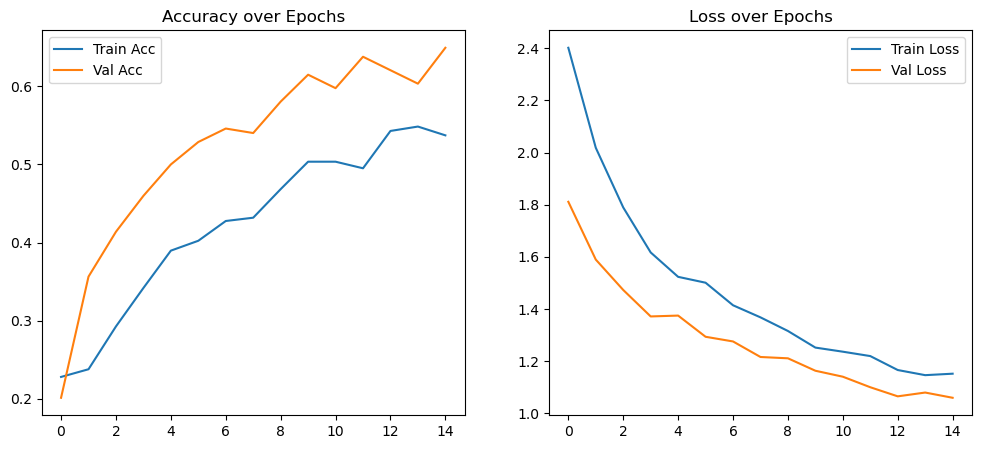

6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 979ms/step
Classification Report
                   precision    recall  f1-score   support

        Bird-drop       0.46      0.27      0.34        41
            Clean       0.67      0.53      0.59        38
            Dusty       0.57      0.68      0.62        38
Electrical-damage       0.73      0.80      0.76        20
  Physical-Damage       0.39      0.69      0.50        13
     Snow-Covered       0.62      0.75      0.68        24

         accuracy                           0.57       174
        macro avg       0.57      0.62      0.58       174
     weighted avg       0.58      0.57      0.56       174



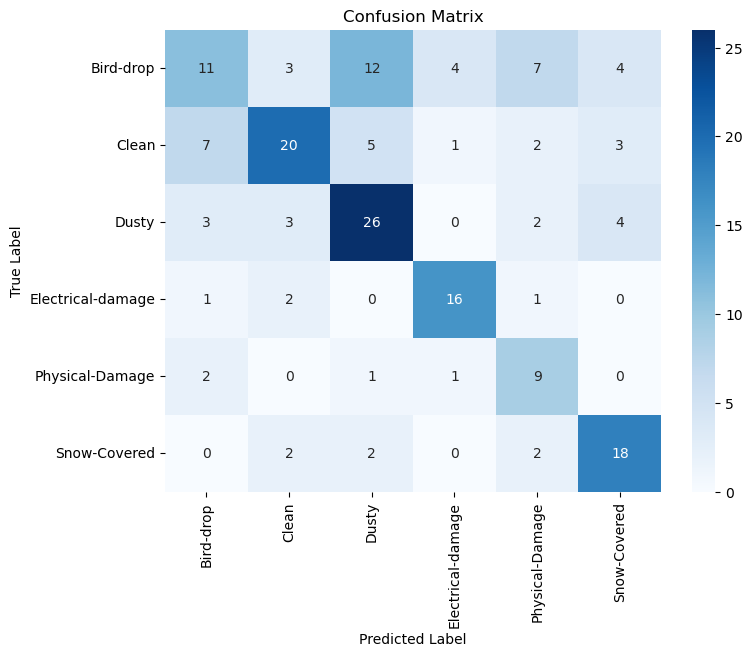

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Parameters
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 15
DATASET_PATH = r"C:\Users\Lenovo\Downloads\Faulty_solar_panel-20250526T164617Z-1-001\Faulty_solar_panel"  # Adjust if needed

# Data Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False  # Important for evaluation
)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# Build Transfer Learning Model
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(6, activation='softmax')(x)  # 6 classes

model = Model(inputs=base_model.input, outputs=outputs)

# Compile
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    class_weight=class_weights
)

# Save model
model.save('solar_panel_transfer_learning_model.h5')

# Plot accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()

# Evaluate and Classification Report
val_generator.reset()
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)

print('Classification Report')
print(classification_report(val_generator.classes, y_pred, target_names=val_generator.class_indices.keys()))

# Confusion Matrix
cm = confusion_matrix(val_generator.classes, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys(), cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
